### Make IPython magic along with a few imports below for visualisation purpose

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from glob import glob
import os
import numpy as np

import sys
sys.path.append('scripts')
import load_utils

# Preprocess CT scans for ROI segmentation

In [3]:
! python scripts/prepare_aorta_segmentation.py -h

usage: prepare_aorta_segmentation.py [-h] [--batch-size N] [--j J] [--n N]
                                     [--s S]
                                     idir odir

Preprocess CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --j J           number of process to run simultaneously
  --n N           maximum number of samples to be processed
  --s S           Skip first S samples


In [4]:
! rm -r ../DM_Data/prepared_aorta_training/
! python scripts/prepare_aorta_segmentation.py ../DM_Data/RIII/ ../DM_Data/prepared_aorta_training/ --n=3
! ls ../DM_Data/prepared_aorta_training/

100%|█████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]
0201R3011  0304R3039  1649R3008


# Train UNet over CT scans for ROI segmentation

In [4]:
! python scripts/train_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_aorta_segmentation.py [-h] [--batch-size N] [--epochs E]
                                   [--split S] [--j J]
                                   idir mdir

Train UNet over CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  mdir            output model directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --epochs E      number of epochs
  --split S       train / test split: train = patient_ids[int(SPLIT *
                  len(patient_ids)):]
  --j J           number of process to run simultaneously


In [5]:
! rm -r ../DM_Data/aorta_model/
! python scripts/train_aorta_segmentation.py ../DM_Data/prepared_aorta_training/ ../DM_Data/aorta_model/ --epochs=3

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/1
2018-02-23 21:53:47.056966: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-23 21:53:47.145030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-23 21:53:47.145362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-23 21:53:47.145393: I tensorflow/core/common_runtime/

# UNet inference over CT scans, ROI segmentation

In [6]:
! python scripts/predict_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_aorta_segmentation.py [-h] [--spacing S] [--batch-size N]
                                     [--TTA T] [--j J] [--pdir PDIR] [--n N]
                                     [--s S]
                                     idir odir mpath

UNet inference over CT scans, ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory
  mpath           path to the model

optional arguments:
  -h, --help      show this help message and exit
  --spacing S     if included isotropic spacing of CT will be forced,
                  otherwise original spacing will be preserved
  --batch-size N  batch size to load in RAM
  --TTA T         whether to have test time augmentations

In [8]:
! rm -r ../DM_Data/predicted_aorta/
! rm -r ../DM_Data/processed_patient/
! python scripts/predict_aorta_segmentation.py ../DM_Data/RIII ../DM_Data/predicted_aorta ../DM_Data/best_aorta_model/unet_model --pdir=../DM_Data/processed_patient --batch-size=32 --spacing=1.0 --s=151 --n=4

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-23 21:56:25.948433: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-23 21:56:26.019707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-23 21:56:26.020056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-23 21:56:26.020095: I tensorflow/core/common_runtime/gpu/gpu_de

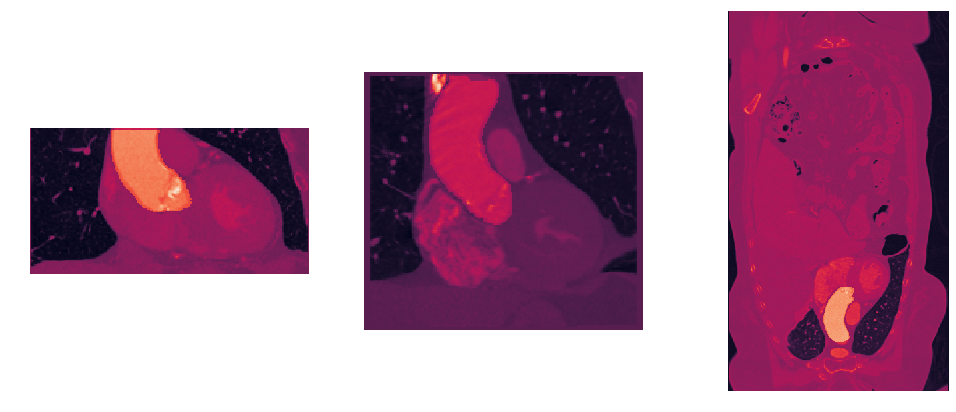

In [6]:
paths = glob('../DM_Data/predicted_aorta/*')
pdir = '../DM_Data/processed_patient'
plt.figure(figsize=(17, 7))

for i in range(3):
    path = np.random.choice(paths)
    mask = np.load(path)
    patch = np.load(os.path.join(pdir, os.path.basename(path)))
    plt.subplot(1, 3, i + 1)
    z, x, y = np.where(mask)
    plt.imshow(patch[:, int(x.mean())] + 750 * mask[:, int(x.mean())])
    plt.axis('off');

# Extract normal planes of CT scans and predicted masks

In [10]:
! python scripts/extract_normals.py -h

usage: extract_normals.py [-h] [--side SIDE] [--j J] [--s S] [--n N]
                          maskdir patdir odir

Extract normal planes of CT scans and predicted masks.

positional arguments:
  maskdir      masks input directory
  patdir       input directory should contains processed patients' CT scans
  odir         output directory

optional arguments:
  -h, --help   show this help message and exit
  --side SIDE  output directory
  --j J        number of process to run simultaneously
  --s S        Skip first S samples
  --n N        maximum number of samples to be processed


In [11]:
! python scripts/extract_normals.py ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/normals_extracted --n=4

Iteration 1/4, patient id: 0763R3028.npy
100%|█████████████████████████████████████████| 169/169 [01:43<00:00,  1.63it/s]
Iteration 2/4, patient id: 0104R3020.npy
100%|█████████████████████████████████████████| 139/139 [00:54<00:00,  2.55it/s]
Iteration 3/4, patient id: 0862R3043.npy
100%|█████████████████████████████████████████| 272/272 [05:20<00:00,  1.18s/it]
Iteration 4/4, patient id: 0753R3029.npy
100%|█████████████████████████████████████████| 265/265 [02:48<00:00,  1.57it/s]


In [49]:
! python scripts/extract_normals.py ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/normals_extracted_test

Iteration 1/382, patient id: 1006R3036.npy
100%|█████████████████████████████████████████| 165/165 [00:30<00:00,  5.37it/s]
Iteration 2/382, patient id: 1006R3002.npy
100%|█████████████████████████████████████████| 211/211 [01:25<00:00,  2.46it/s]
Iteration 3/382, patient id: 1006R3058.npy
100%|█████████████████████████████████████████| 126/126 [01:04<00:00,  1.94it/s]
Iteration 4/382, patient id: 0679R3035.npy
100%|█████████████████████████████████████████| 130/130 [01:57<00:00,  1.11it/s]
Iteration 5/382, patient id: 0862R3150.npy
100%|█████████████████████████████████████████| 171/171 [03:15<00:00,  1.15s/it]
Iteration 6/382, patient id: 0201R3009.npy
100%|█████████████████████████████████████████| 214/214 [01:45<00:00,  2.03it/s]
Iteration 7/382, patient id: 0261R3002.npy
100%|█████████████████████████████████████████| 225/225 [13:18<00:00,  3.55s/it]
Iteration 8/382, patient id: 0763R3040.npy
100%|█████████████████████████████████████████| 134/134 [00:34<00:00,  3.87it/s]
Iteratio

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|█████████████████████████████████████████| 168/168 [01:29<00:00,  1.87it/s]
Iteration 40/382, patient id: 0938R3013.npy
100%|█████████████████████████████████████████| 183/183 [04:20<00:00,  1.42s/it]
Iteration 41/382, patient id: 1053R3032.npy
100%|█████████████████████████████████████████| 230/230 [03:21<00:00,  1.14it/s]
Iteration 42/382, patient id: 0127R3079.npy
100%|█████████████████████████████████████████| 228/228 [46:44<00:00, 12.30s/it]
Iteration 43/382, patient id: 0841R3031.npy
100%|█████████████████████████████████████████| 252/252 [13:05<00:00,  3.12s/it]
Iteration 44/382, patient id: 1006R3068.npy
100%|█████████████████████████████████████████| 184/184 [00:46<00:00,  3.95it/s]
Iteration 45/382, patient id: 0972R3027.npy
100%|█████████████████████████████████████████| 219/219 [01:30<00:00,  2.42it/s]
Iteration 46/382, patient id: 0763R3096.npy
100%|█████████████████████████████████████████| 132/132 [00:33<00:00,  3.98it/s]
Iteration 47/382, patient id: 1184R3014.npy


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|█████████████████████████████████████████| 121/121 [01:40<00:00,  1.21it/s]
Iteration 77/382, patient id: 1184R3027.npy
100%|█████████████████████████████████████████| 107/107 [00:52<00:00,  2.03it/s]
Iteration 78/382, patient id: 0981R3006.npy
100%|█████████████████████████████████████████| 133/133 [01:02<00:00,  2.13it/s]
Iteration 79/382, patient id: 0282R3005.npy
100%|█████████████████████████████████████████| 226/226 [02:39<00:00,  1.42it/s]
Iteration 80/382, patient id: 0261R3013.npy
100%|█████████████████████████████████████████| 195/195 [03:37<00:00,  1.11s/it]
Iteration 81/382, patient id: 0201R3004.npy
100%|█████████████████████████████████████████| 198/198 [01:24<00:00,  2.35it/s]
Iteration 82/382, patient id: 0127R3129.npy
100%|█████████████████████████████████████████| 198/198 [01:35<00:00,  2.07it/s]
Iteration 83/382, patient id: 0763R3021.npy
100%|█████████████████████████████████████████| 129/129 [00:55<00:00,  2.34it/s]
Iteration 84/382, patient id: 0862R3065.npy


# Prepare dataset for valve segmentation (require valve annotated data)

In [12]:
! python scripts/prepare_valve_segmentation.py  -h

usage: prepare_valve_segmentation.py [-h] [--valvecsv VALVECSV] [--test T]
                                     [--s S] [--n N]
                                     ndir mdir patdir odir

Prepare dataset for valve segmentation.

positional arguments:
  ndir                 directory should contains prods & slices directories
                       (output from extract_normals)
  mdir                 directory with valve masks
  patdir               directory with CTs, processed w.r.t. valve masks
  odir                 output directory

optional arguments:
  -h, --help           show this help message and exit
  --valvecsv VALVECSV  csv file: [seriesuid, idx0, idx1] w.r.t. processed CTs
  --test T             Process in test mode
  --s S                Skip first S samples
  --n N                maximum number of samples to be processed


In [17]:
! python scripts/prepare_valve_segmentation.py  ../DM_Data/normals_extracted ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/prepared_valve_training --valvecsv=valve.csv --n=4
! ls ../DM_Data/prepared_valve_training

100%|█████████████████████████████████████████████| 4/4 [00:35<00:00,  8.81s/it]
0104R3020  0261R3002  0763R3028  0862R3150  1006R3002
0201R3009  0753R3029  0862R3043  0939R3004  1006R3058


In [18]:
! python scripts/prepare_valve_segmentation.py  ../DM_Data/normals_extracted_test/ ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/prepared_valve_test --test=True
! ls ../DM_Data/prepared_valve_test

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]
0104R3020  0679R3035  0862R3150  1006R3036
0201R3009  0763R3028  1006R3002  1006R3058


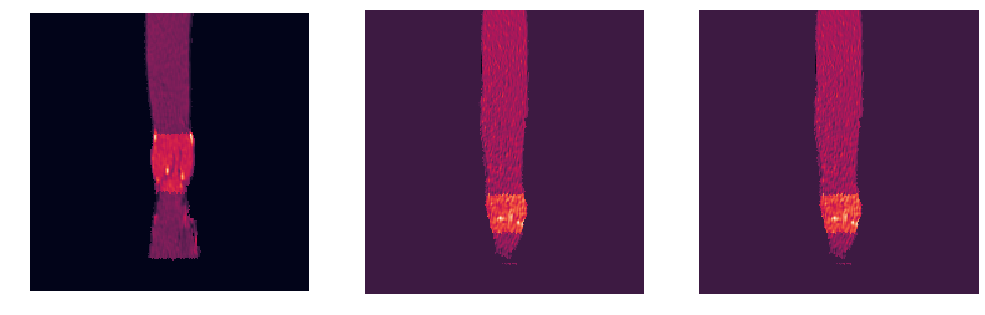

In [137]:
idir = '../DM_Data/prepared_valve_training'
plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    mask = np.load(os.path.join(path, 'mask_0.npy'))
    patch = np.load(os.path.join(path, 'patch_0.npy'))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch + mask)
    plt.axis('off');

# Train valve segmentation model

In [20]:
! python scripts/train_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_valve_segmentation.py [-h] [--epochs E] mdir mpath

Train valve segmentation model.

positional arguments:
  mdir        directory with prepared data (should contains mask_*.npy)
  mpath       path to the model

optional arguments:
  -h, --help  show this help message and exit
  --epochs E  maximum number of epochs to be trained


In [21]:
! python scripts/train_valve_segmentation.py ../DM_Data/prepared_valve_training ../DM_Data/valve_model/mvlv --epochs=2

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/2
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
2018-02-23 22:18:49.523526: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-23 22:18:49.609443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning 

# Predict valve segmentation

In [22]:
! python scripts/predict_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_valve_segmentation.py [-h] [--valvedir VSCV] [--ndir NDIR]
                                     [--mdir MDIR] [--n N] [--s S]
                                     idir odir mpath

Valve segmentation model inference over prepared dataset

positional arguments:
  idir             directory with prepared data (should contains mask_*.npy)
  odir             output directory
  mpath            path to the model

optional arguments:
  -h, --help       show this help message and exit
  --valvedir VSCV  Directory to store predicted valve mapped on 3D
  --ndir NDIR      directory should contains prods & slices directories
                   (output from extract_normals)
  --mdir MDIR      directory with valve masks

In [23]:
! python scripts/predict_valve_segmentation.py ../DM_Data/prepared_valve_test/ ../DM_Data/predicted_valve_test/ ../DM_Data/valve_model/xception_valve

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-23 22:21:32.851389: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-23 22:21:32.937751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-23 22:21:32.938094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-23 22:21:32.938131: I tensorflow/core/common_runtime/gpu/gpu_de

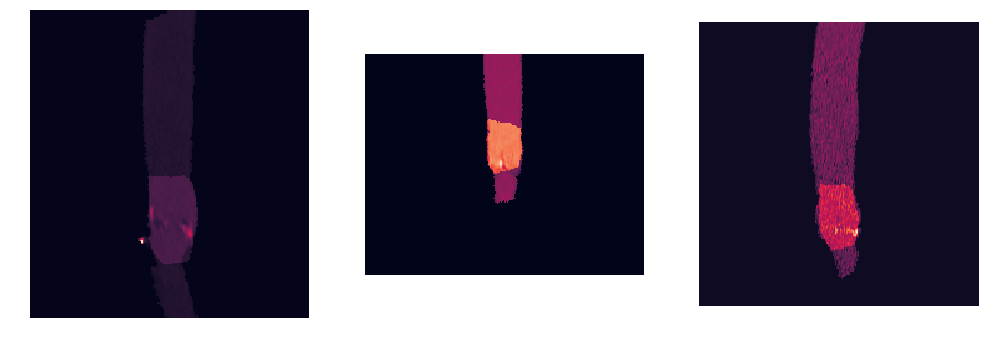

In [147]:
idir = '../DM_Data/predicted_valve/'
mdir = '../DM_Data/prepared_valve_training/'

plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    patch = np.load(os.path.join(mdir, os.path.basename(path)[:-4], 'patch_3.npy'))
    predict = np.load(os.path.join(path))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch[:predict.shape[0], :predict.shape[1]] + predict[:patch.shape[0], :patch.shape[1]])
    plt.axis('off');

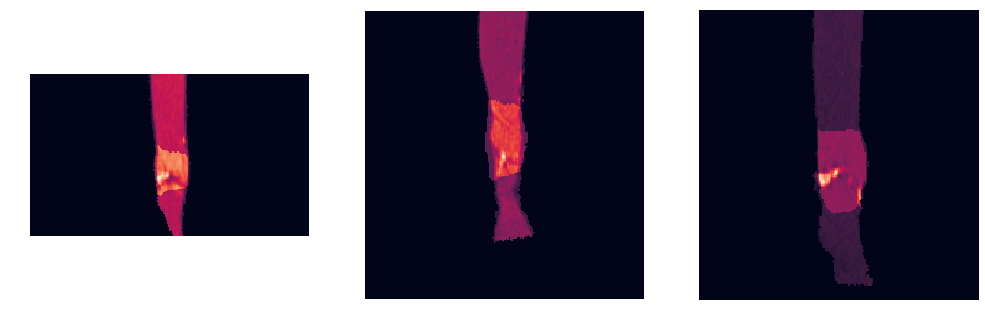

In [ ]:
idir = '../DM_Data/predicted_valve_test/'
mdir = '../DM_Data/prepared_valve_test/'

plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    patch = np.load(os.path.join(mdir, os.path.basename(path)[:-4], 'patch_3.npy'))
    predict = np.load(os.path.join(path))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch[:predict.shape[0], :predict.shape[1]] + predict[:patch.shape[0], :patch.shape[1]])
    plt.axis('off');

# Prepare features

In [26]:
! python scripts/prepare_features.py -h

usage: prepare_features.py [-h] [--exclude_paths EP] [--n N] [--s S]
                           patdir mdir ndir vdir opath

Prepare features for valve size classification.

positional arguments:
  patdir              input directory should contains patients' CT scans
  mdir                masks input directory
  ndir                masks input directory
  vdir                masks input directory
  opath               path to output csv file

optional arguments:
  -h, --help          show this help message and exit
  --exclude_paths EP  path to the pickled version of excluded paths
  --n N               maximum number of samples to be processed
  --s S               Skip first S samples


In [41]:
! python scripts/prepare_features.py ../DM_Data/processed_patient/ ../DM_Data/predicted_aorta ../DM_Data/normals_extracted_test ../DM_Data/predicted_valve_test/ ../DM_Data/features.csv

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


_0, _1 - relates to upper and lower bounds of valve,   
longs - length of an elipce's major axis  
shorts - length of an elipce's minor axis  
large_max -	maximum length among elipces' major axis   
tangs_max - maximum length among elipces' mainor axis   
areas_max - maximum area among all elipces  
areas_min - minimum area among all elipces  
gm_min - mixture of gaussians over valve distrebution minimum mean  
gm_max - mixture of gaussians over valve distrebution maximum mean  

In [59]:
import pandas as pd
pd.read_csv('../DM_Data/features.csv')

,seriesuid,longs_0,shorts_0,ratio_0,longs_1,shorts_1,ratio_1,large_max,tangs_max,areas_max,areas_min,gm_min,gm_max,ratio_idx0,ratio_idx1,gm_diff
0,0763R3028,38.627322,31.639967,918.0,36.469878,32.086174,894.0,44.043837,31.665296,1012.0,794.0,243.412314,316.137582,1.22084,1.136623,-72.725268


In [33]:
paths = glob('../DM_Data/normals_extracted_test/annulus/*.npy')
np.load(np.random.choice(paths))

array([    54.52556595,    131.26210329,     98.06908058,  29688.36784054,
         8374.87164311,  37296.41189078])

In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
import pandas as pd
from tqdm import tqdm
import pickle


# load extracted features
features = pd.read_csv('features')
# load provided annotation
labels_df = pd.read_excel("../DM_Data/REPRISE III Sizes.xlsx")

# clear features dataframe
try:
    features = features.drop(['Unnamed: 0'], axis=1)
except:
    pass

# merge features dataframe with annotations
features = pd.merge(
    labels_df[['Subject name or identifier', 'Valve Size (Model number)']], 
    features, 
    left_on=['Subject name or identifier'], 
    right_on=['seriesuid'],
)

# convert string class into nuber {23mm, 25mm, 27mm} -> {0, 1, 2}
labels = features[['class']]
for label in labels['class'].unique():
    labels[label] = features['class'] == label
labels = labels.drop(['class'], axis=1).values
features = features.drop(['class', 'seriesuid'], axis=1).values

# define leave one out strategy
loo = LeaveOneOut()
predicted = dict()
gt = list()

# create classifiers
clfs = [
        GradientBoostingClassifier(n_estimators=3, max_depth=2, random_state=10)
    ]

# make prediction for each classifier
for clf in clfs:
    predicted[str(clf.__class__)] = list()
    # for each element of LOO
    for split, lo in tqdm(loo.split(features)):
        clf.fit(features[split], np.argmax(labels[split], axis=1))
        predicted[str(clf.__class__)].append(clf.predict_proba(features[lo]))

# make estimation for each classifier
for i, clf in enumerate(clfs):
    pred = np.array(predicted[str(clf.__class__)])
    pred = np.argmax(pred, axis=-1)
    gt = np.argmax(labels, axis=-1)
    print((len(labels) - (np.abs(np.squeeze(pred) - gt) > 0).sum()) / len(labels))


pickle.dump(clfs, open('../Slfs', 'wb'))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
127it [00:00, 187.52it/s]

0.748031496063


# Make the whole prediction cycle

In [35]:
! python scripts/predict.py -h 

usage: predict.py [-h] idir tmpdir mvpath mapath

Prediction pipeline

positional arguments:
  idir        directory with CT scans in .npz format
  tmpdir      intermediate output directory (aorta & valve segmentation will
              be placed there)
  mvpath      path to the valve model
  mapath      path to the aorta model

optional arguments:
  -h, --help  show this help message and exit


In [42]:
! python scripts/predict.py ~/edata/RIII ~/edata/RIII_TMP ../DM_Data/valve_model/xception_valve ../DM_Data/best_aorta_model/unet_model

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-23 22:45:32.205217: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-23 22:45:32.289891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-23 22:45:32.290253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-23 22:45:32.290294: I tensorflow/core/common_runtime/gpu/gpu_de

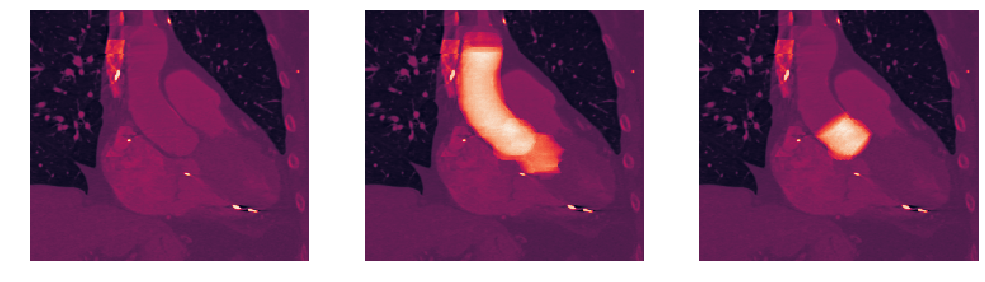

In [100]:
pid = np.random.choice(glob('/home/ubuntu/edata/RIII/*'))
pid = os.path.basename(pid) + '.npy'
path = '/home/ubuntu/edata/RIII_TMP/'

patient = np.load(os.path.join(path, 'processed_patient', pid))
aorta = np.load(os.path.join(path, 'predicted_aorta', pid))
valve = np.load(os.path.join(path, 'prepared_valve_3d', pid))


plt.figure(figsize=(17, 7))

plt.subplot(1, 3, 1)
x_mean = np.where(aorta)[1].mean()
plt.imshow(patient[:, int(x_mean)])
plt.axis('off');

plt.subplot(1, 3, 2)
plt.imshow(patient[:, int(x_mean)] + 70 * aorta.sum(1))
plt.axis('off');

plt.subplot(1, 3, 3)
plt.imshow(patient[:, int(x_mean)] + 70 * valve.sum(1))
plt.axis('off');

In [56]:
features_df = pd.read_csv(os.path.join(path, 'features.csv'))
features_df.head()

,seriesuid,longs_0,shorts_0,ratio_0,longs_1,shorts_1,ratio_1,large_max,tangs_max,areas_max,areas_min,gm_min,gm_max,ratio_idx0,ratio_idx1,gm_diff
0,0753R3028,35.6373,31.773834,886.47162,31.332208,26.582812,646.285077,39.468607,37.000704,1115.082908,649.17889,229.742474,395.486855,1.121593,1.178664,-165.744381


# Class {23mm, 25mm, 27mm} -> {0, 1, 2}

In [49]:
import pickle
clfs = pickle.load(open('../clfs', 'rb'))[0]
clfs.predict(features.drop(['seriesuid'], axis=1))

array([2])